# Imports

In [6]:
from __future__ import print_function

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, Adadelta, Adagrad, Adam, Nadam, SGD
from keras.callbacks import EarlyStopping, TerminateOnNaN
from keras import backend as K
from keras.losses import mean_squared_error
import tensorflow as tf

# Normalize the data.
from sklearn import preprocessing
from keras.regularizers import l1_l2
from sklearn.model_selection import train_test_split
import scipy.io as spio

# Functions

In [7]:
# Compute the RMSE given the ground truth (y_true) and the predictions(y_pred)
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

def PGNN_train_test(optimizer_name, optimizer_val, drop_rate, iteration, n_layers, n_nodes,
                    tr_size, lake_name, use_YPhy):
        
    # Hyper-parameters of the training process
#     batch_size = int(tr_size/2)
    batch_size = 1000
    num_epochs = 1000
    val_frac = 0.25
    patience_val = 100
    
    # Initializing results filename
    exp_name = "Scaled_Lake_Pre-train" + optimizer_name + '_drop' + str(drop_rate) + '_nL' + str(n_layers) + '_nN' + str(n_nodes) + '_trsize' + str(tr_size) + '_iter' + str(iteration)
    exp_name = exp_name.replace('.','pt')
    results_dir = '../../results/Lake/'
    model_name = results_dir + exp_name + '.h5' # storing the trained model
    results_name = results_dir + exp_name + '_results.dat' # storing the results of the model
    
    # Loading unsupervised data
    data_dir = '../../data/'
    unsup_filename = lake_name + '_sampled.mat'
    unsup_mat = spio.loadmat(data_dir+unsup_filename, squeeze_me=True,
    variable_names=['Xc_doy1','Xc_doy2'])
    
    uX1 = unsup_mat['Xc_doy1'] # Xc at depth i for every pair of consecutive depth values
    scaler = preprocessing.StandardScaler()
    uX1 = scaler.fit_transform(uX1)

    uY1 = uX1[:,-1]
    uX1 = uX1[:,:-1]
#     uX2 = unsup_mat['Xc_doy2'] # Xc at depth i + 1 for every pair of consecutive depth values


    
    # train and test data
    trainX, testX, trainY, testY = train_test_split(uX1, uY1, train_size=tr_size/uX1.shape[0], 
                                                    test_size=100/uX1.shape[0], random_state=42, shuffle=True)

    
#     # train and test data
#     trainX, trainY = uX1[:tr_size,:], uY1[:tr_size]
#     testX, testY = uX1[tr_size:,:], uY1[tr_size:]
    
    # Creating the model
    model = Sequential()
    for layer in np.arange(n_layers):
        if layer == 0:
            model.add(Dense(n_nodes, activation='relu', input_shape=(np.shape(trainX)[1],)))
        else:
#              model.add(Dense(n_nodes, activation='relu'))
            model.add(Dense(n_nodes, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
        model.add(Dropout(rate=drop_rate))
    model.add(Dense(1, activation='linear'))

    model.compile(loss='mean_squared_error',
                  optimizer=optimizer_val,
                  metrics=[root_mean_squared_error])
    
    
#     with tf.Session() as sess:
#         init = tf.global_variables_initializer()
#         sess.run(init)
#         print(predictions[:,0].eval())
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience_val,verbose=1)
    
    print('Running...' + optimizer_name)
    history = model.fit(trainX, trainY,
                        batch_size=batch_size,
                        epochs=num_epochs,
                        verbose=1,
                        validation_split=val_frac, callbacks=[early_stopping, TerminateOnNaN()])
#     print(testX)
    test_score = model.evaluate(testX, testY, verbose=0)
    print(test_score[0], test_score[1])
    print('iter: ' + str(iteration) + 
          ' nL: ' + str(n_layers) + ' nN: ' + str(n_nodes) + 
          ' trsize: ' + str(tr_size) + 
          ' TestRMSE: ' + str(test_score[1]))
    
#     predictions = model.predict(uX1) # model output at depth i
#     print(np.sort(predictions[:,0], axis=0))
    
    model.save(model_name)
    
    # save results
    dictnry = {'train_rmse':history.history['root_mean_squared_error'], 
                                'val_rmse':history.history['val_root_mean_squared_error'],
                                'test_rmse':test_score[1]}

    return dictnry, results_name

In [8]:
# Main Function
if __name__ == '__main__':
    
    # List of optimizers to choose from    
    optimizer_names = ['Adagrad', 'Adadelta', 'Adam', 'Nadam', 'RMSprop', 'SGD', 'NSGD']
    optimizer_vals = [Adagrad(clipnorm=1), Adadelta(clipnorm=1), Adam(clipnorm=1), Nadam(clipnorm=1), RMSprop(clipnorm=1), SGD(clipnorm=1.), SGD(clipnorm=1, nesterov=True)]
    
    # selecting the optimizer
    optimizer_num = 2
    optimizer_name = optimizer_names[optimizer_num]
    optimizer_val = optimizer_vals[optimizer_num]
    
    # Selecting Other Hyper-parameters
    drop_rate = 0.1 # Fraction of nodes to be dropped out
    n_layers = 2 # Number of hidden layers
    n_nodes = 15 # Number of nodes per hidden layer

    # Iterating over different training fractions and splitting indices for train-test splits
#     trsize_range = [1500,20,15,10,5]
#     trsize_range = [24]
#     trsize_range = [1303]
    trsize_range = [600000]
    
    iter_range = np.arange(1) # range of iteration numbers for random initialization of NN parameters
    tr_size = trsize_range[0]
    
    #List of lakes to choose from
    lake = ['mendota' , 'mille_lacs']
    lake_num = 0  # 0 : mendota , 1 : mille_lacs
    lake_name = lake[lake_num]
    
    use_YPhy  = 0
    
    # iterating through all possible params
    for iteration in iter_range:
        results, result_file = PGNN_train_test(optimizer_name, optimizer_val, drop_rate, 
                        iteration, n_layers, n_nodes, tr_size, lake_name, use_YPhy )

Running...Adam
Train on 450000 samples, validate on 150000 samples
Epoch 1/1000
450000/450000 [==============================] - 1s 3us/step - loss: 0.3868 - root_mean_squared_error: 0.4308 - val_loss: 0.1708 - val_root_mean_squared_error: 0.2734
Epoch 2/1000
450000/450000 [==============================] - 1s 2us/step - loss: 0.1941 - root_mean_squared_error: 0.3001 - val_loss: 0.1267 - val_root_mean_squared_error: 0.2353
Epoch 3/1000
450000/450000 [==============================] - 1s 2us/step - loss: 0.1497 - root_mean_squared_error: 0.2654 - val_loss: 0.0998 - val_root_mean_squared_error: 0.2113
Epoch 4/1000
450000/450000 [==============================] - 1s 2us/step - loss: 0.1251 - root_mean_squared_error: 0.2439 - val_loss: 0.0839 - val_root_mean_squared_error: 0.1982
Epoch 5/1000
450000/450000 [==============================] - 1s 2us/step - loss: 0.1114 - root_mean_squared_error: 0.2305 - val_loss: 0.0739 - val_root_mean_squared_error: 0.1856
Epoch 6/1000
450000/450000 [=====

Epoch 46/1000
450000/450000 [==============================] - 1s 2us/step - loss: 0.0718 - root_mean_squared_error: 0.1970 - val_loss: 0.0531 - val_root_mean_squared_error: 0.1695
Epoch 47/1000
450000/450000 [==============================] - 1s 2us/step - loss: 0.0711 - root_mean_squared_error: 0.1964 - val_loss: 0.0565 - val_root_mean_squared_error: 0.1793
Epoch 48/1000
450000/450000 [==============================] - 1s 2us/step - loss: 0.0709 - root_mean_squared_error: 0.1961 - val_loss: 0.0501 - val_root_mean_squared_error: 0.1644
Epoch 49/1000
450000/450000 [==============================] - 1s 2us/step - loss: 0.0709 - root_mean_squared_error: 0.1960 - val_loss: 0.0595 - val_root_mean_squared_error: 0.1837
Epoch 50/1000
450000/450000 [==============================] - 1s 2us/step - loss: 0.0709 - root_mean_squared_error: 0.1960 - val_loss: 0.0541 - val_root_mean_squared_error: 0.1742
Epoch 51/1000
450000/450000 [==============================] - 1s 2us/step - loss: 0.0708 - roo

450000/450000 [==============================] - 1s 2us/step - loss: 0.0673 - root_mean_squared_error: 0.1911 - val_loss: 0.0516 - val_root_mean_squared_error: 0.1679
Epoch 91/1000
450000/450000 [==============================] - 1s 2us/step - loss: 0.0674 - root_mean_squared_error: 0.1916 - val_loss: 0.0500 - val_root_mean_squared_error: 0.1640
Epoch 92/1000
450000/450000 [==============================] - 1s 2us/step - loss: 0.0671 - root_mean_squared_error: 0.1912 - val_loss: 0.0486 - val_root_mean_squared_error: 0.1628
Epoch 93/1000
450000/450000 [==============================] - 1s 2us/step - loss: 0.0669 - root_mean_squared_error: 0.1909 - val_loss: 0.0515 - val_root_mean_squared_error: 0.1659
Epoch 94/1000
450000/450000 [==============================] - 1s 2us/step - loss: 0.0669 - root_mean_squared_error: 0.1909 - val_loss: 0.0530 - val_root_mean_squared_error: 0.1727
Epoch 95/1000
450000/450000 [==============================] - 1s 2us/step - loss: 0.0665 - root_mean_squared

Epoch 135/1000
450000/450000 [==============================] - 1s 2us/step - loss: 0.0659 - root_mean_squared_error: 0.1897 - val_loss: 0.0531 - val_root_mean_squared_error: 0.1713
Epoch 136/1000
450000/450000 [==============================] - 1s 2us/step - loss: 0.0657 - root_mean_squared_error: 0.1896 - val_loss: 0.0516 - val_root_mean_squared_error: 0.1664
Epoch 137/1000
450000/450000 [==============================] - 1s 2us/step - loss: 0.0659 - root_mean_squared_error: 0.1900 - val_loss: 0.0527 - val_root_mean_squared_error: 0.1702
Epoch 138/1000
450000/450000 [==============================] - 1s 2us/step - loss: 0.0658 - root_mean_squared_error: 0.1899 - val_loss: 0.0540 - val_root_mean_squared_error: 0.1729
Epoch 139/1000
450000/450000 [==============================] - 1s 2us/step - loss: 0.0659 - root_mean_squared_error: 0.1899 - val_loss: 0.0562 - val_root_mean_squared_error: 0.1730
Epoch 140/1000
450000/450000 [==============================] - 1s 2us/step - loss: 0.0656

Epoch 180/1000
450000/450000 [==============================] - 1s 2us/step - loss: 0.0658 - root_mean_squared_error: 0.1900 - val_loss: 0.0524 - val_root_mean_squared_error: 0.1683
Epoch 181/1000
450000/450000 [==============================] - 1s 2us/step - loss: 0.0655 - root_mean_squared_error: 0.1895 - val_loss: 0.0488 - val_root_mean_squared_error: 0.1629
Epoch 182/1000
450000/450000 [==============================] - 1s 2us/step - loss: 0.0655 - root_mean_squared_error: 0.1895 - val_loss: 0.0533 - val_root_mean_squared_error: 0.1694
Epoch 183/1000
450000/450000 [==============================] - 1s 2us/step - loss: 0.0657 - root_mean_squared_error: 0.1896 - val_loss: 0.0541 - val_root_mean_squared_error: 0.1730
Epoch 184/1000
450000/450000 [==============================] - 1s 2us/step - loss: 0.0655 - root_mean_squared_error: 0.1897 - val_loss: 0.0504 - val_root_mean_squared_error: 0.1649
Epoch 185/1000
450000/450000 [==============================] - 1s 2us/step - loss: 0.0656

In [95]:
# # Loading unsupervised data
# data_dir = '../../data/'
# unsup_filename = 'mendota' + '_sampled.mat'
# unsup_mat = spio.loadmat(data_dir+unsup_filename, squeeze_me=True,
# variable_names=['Xc_doy1','Xc_doy2'])

# uX1 = unsup_mat['Xc_doy1'] # Xc at depth i for every pair of consecutive depth values
# uY1 = uX1[:,-1]
# uX1 = uX1[:,:-1]

# pd.DataFrame(uX1)[4].unique().shape

# pd.DataFrame(uX1).iloc[:150,:]

In [96]:
# model.load(model_name)
# prediction = model.predict(np.array(tk.texts_to_sequences(text)))
# print(prediction)

In [97]:
dict_keys = []

# get key and value 
print ("Dict keys are: ") 
for key, value in results.items(): 
    dict_keys.append(key)

print(dict_keys)
train_rmse = results[dict_keys[0]]
val_rmse = results[dict_keys[1]]
test_rmse = results[dict_keys[2]]
print("Test RMSE: ",test_rmse)

Dict keys are: 
['train_rmse', 'val_rmse', 'test_rmse']
Test RMSE:  0.20168207585811615


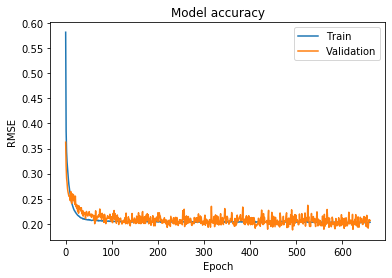

In [98]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure()
plt.plot(train_rmse)
plt.plot(val_rmse)
plt.title('Model accuracy')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()